In [57]:
import torch
from datasets import Dataset, DatasetDict, IterableDataset, load_dataset,load_from_disk
import hashlib
# 示例文件路径
file_path = "/data/changye/data/RLAIF-V_interp/RLAIFV_l0.pt"

# 读取 .pt 文件
data = torch.load(file_path)




/tmp/ipykernel_2828770/3877639395.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


In [54]:
# 查看数据
print(type(data[0]))  # 查看数据类型
# print(len(data[0].keys()))   # 打印数据内容（可能是张量、字典、列表等）
# print(data[0].keys())
# print(data[1].keys())
common_keys = set(data[0].keys()) & set(data[1].keys())
print(common_keys)
print(data[0]['OmniLMM-12B_OmniLMM-12B_3392'])
print(data[1]['OmniLMM-12B_OmniLMM-12B_3392'])

<class 'dict'>
{'OmniLMM-12B_OmniLMM-12B_3388', 'OmniLMM-12B_OmniLMM-12B_3386', 'OmniLMM-12B_OmniLMM-12B_3394', 'OmniLMM-12B_OmniLMM-12B_3387', 'OmniLMM-12B_OmniLMM-12B_3390', 'OmniLMM-12B_OmniLMM-12B_3393', 'OmniLMM-12B_OmniLMM-12B_3389', 'OmniLMM-12B_OmniLMM-12B_3396', 'OmniLMM-12B_OmniLMM-12B_3391', 'OmniLMM-12B_OmniLMM-12B_3397', 'OmniLMM-12B_OmniLMM-12B_3398', 'OmniLMM-12B_OmniLMM-12B_3395', 'OmniLMM-12B_OmniLMM-12B_3392', 'OmniLMM-12B_OmniLMM-12B_3399'}
tensor(136.6045, device='cuda:5')
tensor(167.7956, device='cuda:5')


In [ ]:
# data_list={}
# for data_l in data:
#     for dic in data_l.keys():
#         data_list[dic]=data_l[dic]

In [ ]:
# print(len(data_list))
# print(len(data_list.keys()))

23861
23861


In [ ]:
dataset_path="/data/changye/data/RLAIF-V-Dataset"
train_dataset = load_dataset(
            dataset_path,
            trust_remote_code=True,
        )

Generating train split: 0 examples [00:00, ? examples/s]

In [61]:
def generate_text_hash(text: str) -> str:
    """
    Generate a unique identifier for the given text using SHA-256.

    Args:
        text (str): Input text.

    Returns:
        str: Unique hash for the text.
    """
    hash_object = hashlib.sha256(text.encode('utf-8'))
    return hash_object.hexdigest()



In [62]:
def add_question_hash(example):
    example['question_hash'] = generate_text_hash(example['question'])
    return example

# 假设 train_dataset 是 DatasetDict 类型，直接应用 map 方法
updated_train_dataset = train_dataset.map(
    add_question_hash,
    batched=False,  # 对每一行单独处理
    load_from_cache_file=False  # 如果修改数据，关闭缓存加载
)

Map:   0%|          | 0/83132 [00:00<?, ? examples/s]

In [65]:
print(updated_train_dataset)
idx_list=updated_train_dataset['train']['idx']
hash_list=updated_train_dataset['train']['question_hash']
data_idx_list=[]
data_value_list=[]
for data_l in data:
    for dic in data_l.keys():
        data_idx_list.append(dic)
        data_value_list.append(data_l[dic])

DatasetDict({
    train: Dataset({
        features: ['ds_name', 'image', 'question', 'chosen', 'rejected', 'origin_dataset', 'origin_split', 'idx', 'image_path', 'question_hash'],
        num_rows: 83132
    })
})


In [69]:
for i,data_l in enumerate(data):
    if len(data_l)==1000:
        continue
    print(i)

8
10
12
19
20
29
42
45
48
52
62
76


In [67]:
print(len(data_idx_list))
print(len(idx_list))

81714
83132


In [27]:
#我现在有一个dict，键为'image_name'，值为一个浮点数，我希望按照值的大小进行排序，然后我有一个数据集以'image_name'为索引，结构为Dataset({
#     features: ['image', 'question', 'chosen', 'rejected', 'image_name'],
#     num_rows: 93258
# })
#我希望能够按照这个排序对这个dataset进行筛选保存，能够保存前25%，25%到50%这样按百分比保存的值，以huggingfacedataset的形式存储，请补全以下代码
# Step 1: Sort image_names based on their corresponding values in 'data'
sorted_image_names = sorted(data_list, key=data_list.get, reverse=True)

# Step 2: Compute indices for the percentiles
total_images = len(sorted_image_names)
percentiles = [0.25, 0.5, 0.75, 1.0]
indices = [int(total_images * p) for p in percentiles]

# Step 3: Create ranges for each percentile
start_indices = [0] + indices[:-1]
end_indices = indices
ranges = list(zip(start_indices, end_indices))

# Step 4: Filter and save datasets for each percentile range
for idx, (start, end) in enumerate(ranges):
    # Get the image_names for the current percentile range
    image_name_set = set(sorted_image_names[start:end])

    # Filter the dataset based on the image_name_set
    percentile_dataset = train_dataset.filter(lambda example: example['image_name'] in image_name_set)

    # Save the filtered dataset
    percentile_label = f"{int(percentiles[idx]*100)}%"
    percentile_dataset.save_to_disk(f'percentile_{percentile_label}_dataset')

    print(f"Saved {percentile_label} dataset with {len(percentile_dataset)} samples.")

Filter:   0%|          | 0/93258 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/22449 [00:00<?, ? examples/s]

Saved 25% dataset with 22449 samples.


Filter:   0%|          | 0/93258 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/22450 [00:00<?, ? examples/s]

Saved 50% dataset with 22450 samples.


Filter:   0%|          | 0/93258 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/22449 [00:00<?, ? examples/s]

Saved 75% dataset with 22449 samples.


Filter:   0%|          | 0/93258 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/22450 [00:00<?, ? examples/s]

Saved 100% dataset with 22450 samples.


In [31]:
print(sorted_image_names[1])
print(data_list['19155.png'])

19155.png
tensor(204.1465, device='cuda:5')


/tmp/ipykernel_2828770/3307676455.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


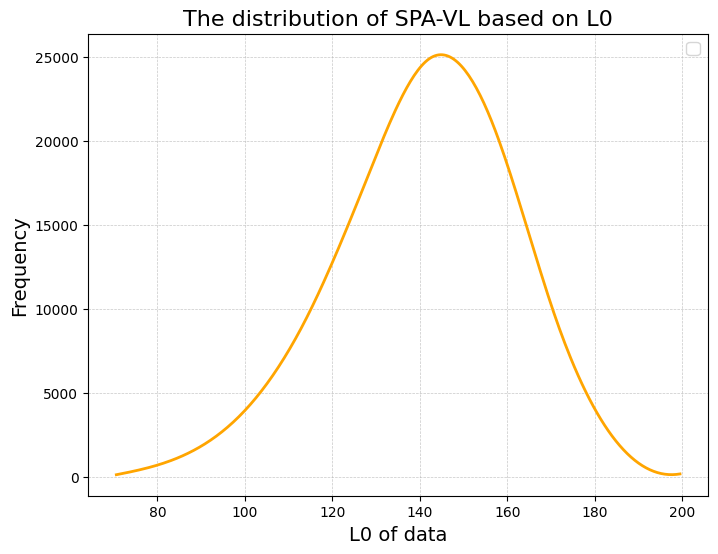

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from collections import Counter

# 假设 data_list 是一个包含数值的列表
# 例如：
# data_list = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]
values_list = [tensor.cpu().item() if tensor.is_cuda else tensor.item() for tensor in data_list.values()]
# 统计频率
num_bins = 10

# 生成直方图
frequencies, bin_edges = np.histogram(values_list, bins=num_bins)

# 计算每个区间的中心点（用于插值）
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 使用样条插值将直方图转换为平滑曲线
bin_centers_smooth = np.linspace(bin_centers[0], bin_centers[-1], 300)  # 插值点
frequencies_smooth = make_interp_spline(bin_centers, frequencies)(bin_centers_smooth)

# 绘图
plt.figure(figsize=(8, 6))
plt.plot(bin_centers_smooth, frequencies_smooth, color='orange', lw=2)


# 样式设置
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel('L0 of data', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('The distribution of SPA-VL based on L0', fontsize=16)
plt.legend(fontsize=12)
plt.show()
